# Installation of Essential Libraries
---

In [ ]:
!pip install torch torchvision datasets scikit-learn matplotlib seaborn --quiet

In [ ]:
!pip install torchinfo

# Library Imports and Computational Device Configuration
---

In [2]:
import torch
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F
from datasets import load_dataset
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wmi
import psutil
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_name = torch.cuda.get_device_name(0)
gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
# Processor name
w = wmi.WMI()
cpu_name = w.Win32_Processor()[0].Name
# Total RAM in GB
ram_size_gb = psutil.virtual_memory().total / (1024**3)
print("Using device:", device)
print("--"*25)
print("PC Confiugration: ")
print(f"Processor: {cpu_name}")
print(f"Total RAM: {ram_size_gb:.2f} GB")
print(f"GPU: {gpu_name}")
print(f"Total GPU Memory: {gpu_memory:.2f} GB")
print("--"*25)

Using device: cuda
--------------------------------------------------
PC Confiugration: 
Processor: 13th Gen Intel(R) Core(TM) i9-13900K
Total RAM: 63.78 GB
GPU: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.99 GB
--------------------------------------------------


# Dataset Loading and Preprocessing for Fashion-MNIST
---

In [3]:
# Load Hugging Face MNIST
ds = load_dataset("zalando-datasets/fashion_mnist")

# Convert to PyTorch tensors
def hf_to_torch(dataset):
    images = torch.tensor(np.array(dataset["image"])).float().div(255.0).unsqueeze(1)  # shape (N, 1, 28, 28)
    labels = torch.tensor(dataset["label"])
    return TensorDataset(images, labels)

train_dataset = hf_to_torch(ds["train"])
test_dataset = hf_to_torch(ds["test"])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 60000, Test samples: 10000


# Class Distribution Analysis in Fashion-MNIST
---

## Determining the Number of Classes
---

In [4]:
train_labels = ds["train"]["label"]
num_classes = len(np.unique(train_labels))
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 10


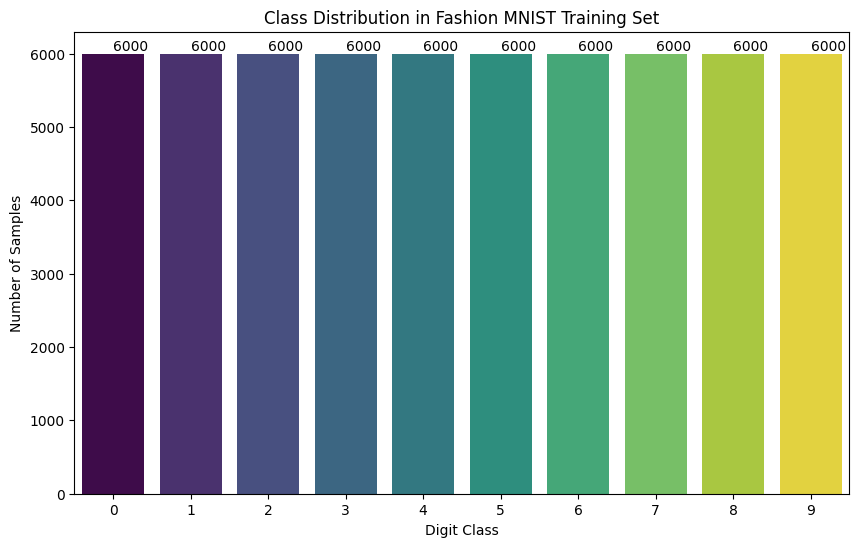

In [5]:
class_counts = np.bincount(train_labels)
class_labels = np.arange(num_classes)

# Ploting
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts, hue=class_labels, palette="viridis", legend=False)
plt.title("Class Distribution in Fashion MNIST Training Set")
plt.xlabel("Digit Class")
plt.ylabel("Number of Samples")
plt.xticks(class_labels)
for i, v in enumerate(class_counts):
    plt.text(i, v, str(v), color='black', va="bottom")
plt.savefig("class_distribution of fashion mnist training set.png")
plt.show()

# Quantitative Assessment of Dataset Imbalance
---

## Statistical Evaluation of Class Sample Distribution
---

In [6]:
mean_samples = np.mean(class_counts)
std_samples = np.std(class_counts)
imbalance_threshold = mean_samples * 0.1
is_imbalanced = std_samples > imbalance_threshold
print(f"Mean samples per class: {mean_samples:.0f}")
print(f"Standard deviation of samples: {std_samples:.0f}")
print(f"Imbalance threshold (10% of mean): {imbalance_threshold:.0f}")
print(f"Is the dataset imbalanced? {'Yes' if is_imbalanced else 'No'}")

Mean samples per class: 6000
Standard deviation of samples: 0
Imbalance threshold (10% of mean): 600
Is the dataset imbalanced? No


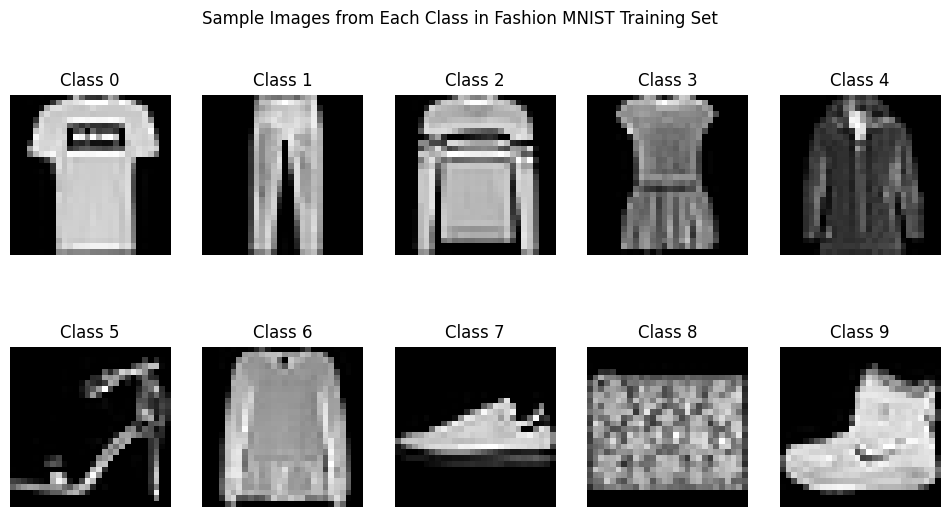

In [7]:
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    class_indices = np.where(np.array(train_labels) == i)[0]
    sample_idx = class_indices[0] 
    image = ds["train"]["image"][sample_idx]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Class {i}")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class in Fashion MNIST Training Set")
plt.savefig("sample_images of fashion mnist.png")
plt.show()

# Initial Clustering Analysis on Raw Fashion-MNIST Training Images
---

## Feature Representation and Preprocessing
---

In [8]:
# Converting raw training images into tensors and normalize pixel values
raw_train_images = torch.tensor(np.array(ds["train"]["image"])).float().div(255.0)

# Reshaping images into flattened vectors for clustering
raw_train_images_flat = raw_train_images.view(-1, 28*28).numpy()

## K-Means Clustering on Unprocessed Image Data
---

In [9]:
# K-Means clustering with 10 clusters to classify raw images
kmeans_init = KMeans(n_clusters=10, n_init=20, random_state=42)
initial_kmeans_labels = kmeans_init.fit_predict(raw_train_images_flat)

print("Initial clustering completed.")

Initial clustering completed.


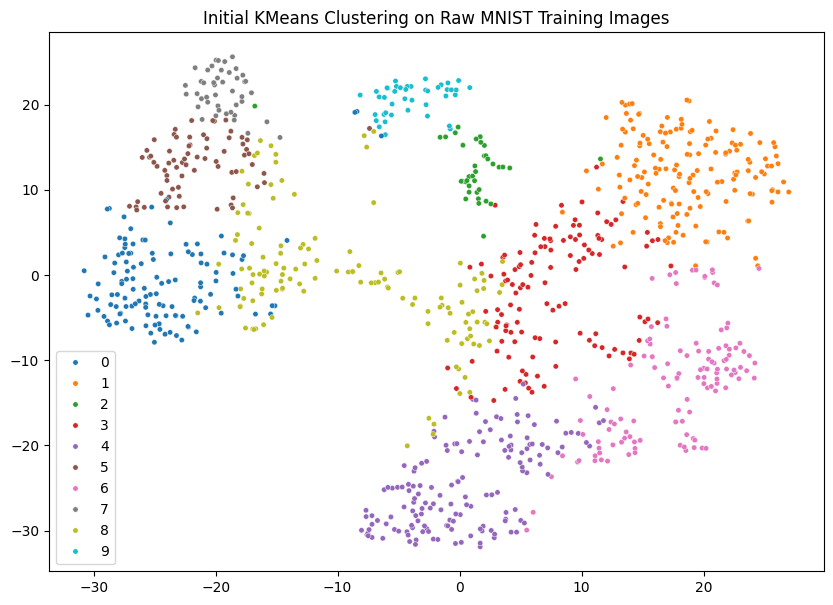

Visualization completed. Plot saved as 'initial_clustering_raw.png'.


In [10]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500)
raw_images_2d = tsne.fit_transform(raw_train_images_flat[:1000])

# Plot clustering results using a scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=raw_images_2d[:, 0], y=raw_images_2d[:, 1], hue=initial_kmeans_labels[:1000], palette='tab10', s=15)
plt.title("Initial KMeans Clustering on Raw MNIST Training Images")
plt.savefig('initial_KMeans clustering_raw_data.png')
plt.show()
plt.close()

print("Visualization completed. Plot saved as 'initial_clustering_raw.png'.")

# Preprocessing Pipeline for RSWNet Compatible Image Input
---

## Conversion of Grayscale Images to 3-Channel Format
---

In [11]:
# Expanding 1-channel grayscale image to 3-channel, resize to 224x224
def preprocess_for_RSWNet(batch):
    batch = F.interpolate(batch, size=(224, 224), mode='bilinear', align_corners=False)
    batch = batch.repeat(1, 3, 1, 1)  # Converting 1 channel to 3
    return batch

## Batch Retrieval and Shape Analysis
---

In [12]:
# Retrieve one batch from the training dataset
images, labels = next(iter(train_loader))

# Original Batch Size
print("Original batch shape:", images.shape)

Original batch shape: torch.Size([128, 1, 28, 28])


## RSWNet Compatible Preprocessing and Verification
---

In [13]:
# Applying preprocessing for RSWNet compatibility
inputs = preprocess_for_RSWNet(images)

# Print new batch shape after preprocessing
print("After preprocess_for_RSWnet:", inputs.shape)

After preprocess_for_RSWnet: torch.Size([128, 3, 224, 224])


# RSWNet architecture for feature extraction and reconstruction
---

Encoder Architecture: Feature Extraction Using Pretrained ResNet50

Decoder Architecture: Upsampling for Image Reconstruction

---

In [14]:
class RSWNetAutoencoder(nn.Module):
    def __init__(self, base_model="resnet50", pretrained=True):
        super().__init__()
        # Loading torchvision ResNet50 and removed avgpool and fully connected layers
        backbone = getattr(models, base_model)(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])

        # Determine output feature dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            feat = self.encoder(dummy)
        feat_dim = feat.shape[1]      # ← 2048 for resnet50
        self._feat_dim = feat_dim     

        # Decoder to mirror feature depth
        # Upsampling from (feat_dim x 7 x 7) to (1 x 28 x 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(feat_dim, feat_dim // 2, kernel_size=3, stride=2, padding=1, output_padding=1),  # → (feat_dim/2 x 14 x 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(feat_dim // 2, feat_dim // 4, kernel_size=3, stride=2, padding=1, output_padding=1),  # → (feat_dim/4 x 28 x 28)
            nn.ReLU(True),
            # Refinement Layer
            nn.Conv2d(feat_dim // 4, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            # Final layer converting to grayscale
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = z.mean(dim=[2,3])
        recon = self.decoder(z)
        return recon, z_flat


## Model Initialization and Optimization Setup
---

In [16]:
rswnetautoencoder = RSWNetAutoencoder(base_model="resnet50").to(device)
# Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rswnetautoencoder.parameters(), lr=1e-3)

print("Encoder output channels:", rswnetautoencoder._feat_dim)

Encoder output channels: 2048


## Training Loop: Loss Computation and Model Optimization
---

In [17]:
num_epochs = 10
for epoch in range(num_epochs):
    # Training Phase
    rswnetautoencoder.train()
    running_train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_RSWNet(images)
        outputs, _ = rswnetautoencoder(inputs) 
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)

    # Validation Phase
    rswnetautoencoder.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            inputs = preprocess_for_RSWNet(images)
            outputs, _ = rswnetautoencoder(inputs) 
            loss = criterion(outputs, images)

            running_val_loss += loss.item() * images.size(0)

    avg_val_loss = running_val_loss / len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss:   {avg_val_loss:.4f}")


Epoch [1/10]  Train Loss: 0.0068  Val Loss:   0.0007
Epoch [2/10]  Train Loss: 0.0005  Val Loss:   0.0002
Epoch [3/10]  Train Loss: 0.0002  Val Loss:   0.0003
Epoch [4/10]  Train Loss: 0.0003  Val Loss:   0.0002
Epoch [5/10]  Train Loss: 0.0002  Val Loss:   0.0001
Epoch [6/10]  Train Loss: 0.0002  Val Loss:   0.0001
Epoch [7/10]  Train Loss: 0.0001  Val Loss:   0.0001
Epoch [8/10]  Train Loss: 0.0001  Val Loss:   0.0001
Epoch [9/10]  Train Loss: 0.0001  Val Loss:   0.0001
Epoch [10/10]  Train Loss: 0.0001  Val Loss:   0.0001


# RSWNet Model Architecture:
---

## Integration with RSWNetAutoencoder
---

In [18]:
class RSWNet(nn.Module):
    def __init__(self, autoencoder, n_clusters=10, latent_dim=64):
        super(RSWNet, self).__init__()
        self.autoencoder = autoencoder
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.cluster_centers = nn.Parameter(torch.randn(n_clusters, latent_dim))

    def forward(self, x):
        _, z = self.autoencoder(x)  # Extract latent representation
        q = self.soft_assign(z)  #Soft cluster assignment
        return z, q

    def soft_assign(self, z):
        dist = torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2)
        q = 1.0 / (1.0 + dist)
        q = q ** ((1 + 1) / 2)
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target Distribution and Clustering Loss Function
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

def kl_divergence(p, q):
    return torch.sum(p * torch.log((p + 1e-6) / (q + 1e-6)), dim=1).mean()


## Initialization of RSWNet Model with K-Means Clustering
---

In [19]:
# Freeze decoder to focus on clustering
for p in rswnetautoencoder.decoder.parameters():
    p.requires_grad = False

# Gather latent features
rswnetautoencoder.eval()
latent_list = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        inputs =preprocess_for_RSWNet(images)  # Resize & convert to 3-channel
        _, z = rswnetautoencoder(inputs)  # Extract latent features
        latent_list.append(z.cpu())

latent_features = torch.cat(latent_list, dim=0).numpy()

# Initialize K-Means clustering
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
kmeans.fit(latent_features)

# Initialize RSWNet Model
rswNet_model = RSWNet(rswnetautoencoder, n_clusters=10, latent_dim=latent_features.shape[1]).to(device)
rswNet_model.cluster_centers.data.copy_(
    torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=device)
)

tensor([[0.3000, 0.4114, 0.3171,  ..., 0.3800, 0.3172, 0.2076],
        [0.7381, 1.2925, 0.8897,  ..., 1.1225, 0.8362, 0.6479],
        [0.0935, 0.0256, 0.0392,  ..., 0.0031, 0.0550, 0.0063],
        ...,
        [0.0615, 0.0138, 0.1237,  ..., 0.0023, 0.0412, 0.0208],
        [0.8849, 1.5681, 1.0744,  ..., 1.3376, 1.0043, 0.7908],
        [0.1998, 0.2090, 0.1878,  ..., 0.2072, 0.1929, 0.1053]],
       device='cuda:0')

## Fine-Tuning RSWNet Model Using Clustering Loss
---

In [20]:
rswnet_optimizer = optim.Adam(rswNet_model.parameters(), lr=1e-3)
num_rswnet_epochs = 10

for epoch in range(num_rswnet_epochs):
    # Training Phase
    rswNet_model.train()
    train_kl = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_RSWNet(images)
        z, q = rswNet_model(inputs)
        p = target_distribution(q.detach())

        # KL loss + backward
        loss = kl_divergence(p, q)
        rswnet_optimizer.zero_grad()
        loss.backward()
        rswnet_optimizer.step()

        train_kl += loss.item() * images.size(0)

    avg_train_kl = train_kl / len(train_loader.dataset)

    # Validation Phase
    rswNet_model.eval()
    val_kl = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            inputs = preprocess_for_RSWNet(images)

            z, q = rswNet_model(inputs)
            p = target_distribution(q)

            loss = kl_divergence(p, q)
            val_kl += loss.item() * images.size(0)

    avg_val_kl = val_kl / len(test_loader.dataset)

    print(f"RSWNet Epoch [{epoch+1}/{num_rswnet_epochs}]  "
          f"Train KL: {avg_train_kl:.6f}  "
          f"Val KL:   {avg_val_kl:.6f}")
rswNet_val_kl = avg_val_kl


RSWNet Epoch [1/10]  Train KL: 0.116420  Val KL:   0.113116
RSWNet Epoch [2/10]  Train KL: 0.103574  Val KL:   0.103659
RSWNet Epoch [3/10]  Train KL: 0.096892  Val KL:   0.094751
RSWNet Epoch [4/10]  Train KL: 0.092694  Val KL:   0.100392
RSWNet Epoch [5/10]  Train KL: 0.087253  Val KL:   0.104113
RSWNet Epoch [6/10]  Train KL: 0.102376  Val KL:   0.106686
RSWNet Epoch [7/10]  Train KL: 0.101075  Val KL:   0.081036
RSWNet Epoch [8/10]  Train KL: 0.091155  Val KL:   0.097873
RSWNet Epoch [9/10]  Train KL: 0.097427  Val KL:   0.113973
RSWNet Epoch [10/10]  Train KL: 0.100847  Val KL:   0.088171


# Model Summary and Computational Analysis for RSWNet
---

## Structural Overview of RSWNet Autoencoder
---

In [21]:
summary(rswnetautoencoder, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
RSWNetAutoencoder                             [1, 1, 28, 28]            --
├─Sequential: 1-1                             [1, 2048, 7, 7]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [22]:
print(rswnetautoencoder)

RSWNetAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

## Structural Overview of RSWNet Clustering Model
---

In [23]:
summary(rswNet_model, input_size=(1, 3, 224, 224), depth=3)

Layer (type:depth-idx)                             Output Shape              Param #
RSWNet                                             [1, 2048]                 20,480
├─RSWNetAutoencoder: 1-1                           [1, 1, 28, 28]            --
│    └─Sequential: 2-1                             [1, 2048, 7, 7]           --
│    │    └─Conv2d: 3-1                            [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 256, 56, 56]          215,808
│    │    └─Sequential: 3-6                        [1, 512, 28, 28]          1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 14, 14]         7,098,368
│    │    └─Sequential: 3-8                        [1, 2048, 7, 7]           14,964,736


In [24]:
print(rswNet_model)

RSWNet(
  (autoencoder): RSWNetAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=Tru

# Evaluation of RSWNet Clustering Performance
---

## Extraction of Latent Representations from Test Images
---

In [25]:
rswNet_model.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        inputs = preprocess_for_RSWNet(images)
        _, z = rswNet_model.autoencoder(inputs)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

all_latents = np.vstack(all_latents)
all_labels = np.hstack(all_labels)

## Final K-Means Clustering on Latent Representations
---

In [26]:
kmeans_final = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans_final.fit_predict(all_latents)

## Quantitative Assessment of Clustering Performance of RSWNet
---

In [27]:
# Metrics
sil_score_rswNet = silhouette_score(all_latents, cluster_labels)
db_score_rswNet = davies_bouldin_score(all_latents, cluster_labels)
ch_score_rswNet = calinski_harabasz_score(all_latents, cluster_labels)

print(f"Silhouette Score:        {sil_score_rswNet:.4f}")
print(f"Davies-Bouldin Index:    {db_score_rswNet:.4f}")
print(f"Calinski-Harabasz Index: {ch_score_rswNet:.4f}")
print(f"{'KL:'} {rswNet_val_kl:.4f}")

Silhouette Score:        0.6799
Davies-Bouldin Index:    0.4570
Calinski-Harabasz Index: 146067.7031
KL: 0.0882


# Visualization of Latent Feature Clustering
---

## K-Means Clustering after training model
---

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


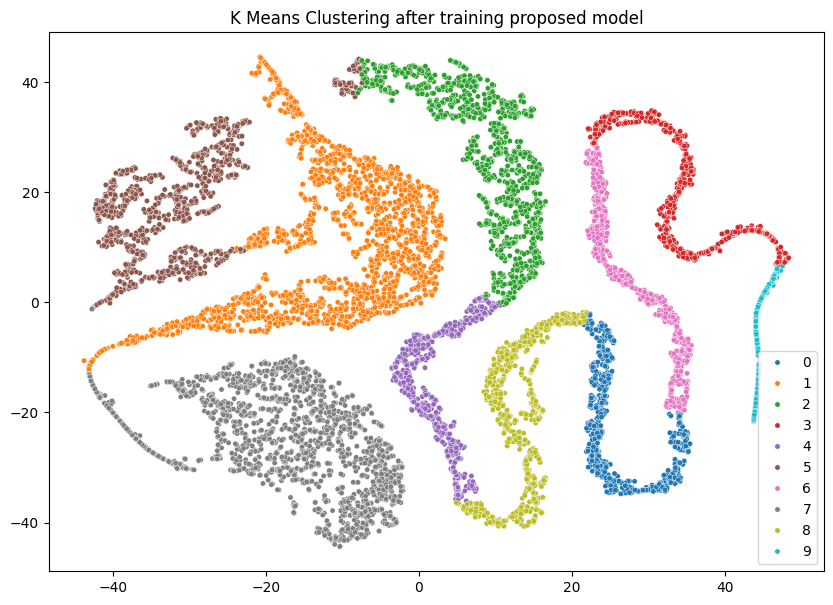

In [28]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
latents_2d = tsne.fit_transform(all_latents)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=cluster_labels, palette='tab10', legend='full', s=15)
plt.title("K Means Clustering after training proposed model")
plt.savefig("Proposed model's K-Means Clustering")
plt.show()


# SOM Implemenetation
---

In [29]:
class SOM:
    def __init__(self, map_size, input_dim, learning_rate=0.5, sigma=None):
        self.map_size = map_size  
        self.input_dim = input_dim  
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(map_size) / 2
        self.weights = torch.randn(map_size[0], map_size[1], input_dim).to(device)
        self.weights = self.weights / torch.norm(self.weights, dim=2, keepdim=True)
        x, y = torch.meshgrid(torch.arange(map_size[0]), torch.arange(map_size[1]), indexing='ij')
        self.grid = torch.stack([x, y], dim=-1).float().to(device)  

    def get_bmu(self, x):
        dists = torch.cdist(x.unsqueeze(1), self.weights.view(-1, self.input_dim)).squeeze(1)
        bmu_indices = dists.argmin(dim=1)
        bmu_coords = torch.stack([bmu_indices // self.map_size[1], bmu_indices % self.map_size[1]], dim=1)
        return bmu_coords

    def update(self, x, t, max_iter):
        lr = self.learning_rate * np.exp(-t / max_iter)
        sigma_t = self.sigma * np.exp(-t / max_iter)
        bmu_coords = self.get_bmu(x) 
        for i in range(x.shape[0]):
            dist_to_bmu = torch.norm(self.grid - bmu_coords[i].float(), dim=2)
            influence = torch.exp(-dist_to_bmu**2 / (2 * sigma_t**2))
            delta = lr * influence.unsqueeze(-1) * (x[i] - self.weights)
            self.weights += delta

    def predict(self, x):
        dists = torch.cdist(x.unsqueeze(1), self.weights.view(-1, self.input_dim)).squeeze(1)
        bmu_indices = dists.argmin(dim=1)
        return bmu_indices.cpu().numpy()


## Extract Latent feature
---

In [30]:
rswnetautoencoder.eval()
latent_features = []
test_latents = []
test_labels = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        inputs = preprocess_for_RSWNet(images)
        _, z = rswnetautoencoder(inputs)
        latent_features.append(z.cpu().numpy())
    for images, labels in test_loader:
        images = images.to(device)
        inputs = preprocess_for_RSWNet(images)
        _, z = rswnetautoencoder(inputs)
        test_latents.append(z.cpu().numpy())
        test_labels.append(labels.numpy())

latent_features = np.vstack(latent_features)
test_latents = np.vstack(test_latents)
test_labels = np.hstack(test_labels)

latent_dim = latent_features.shape[1]

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


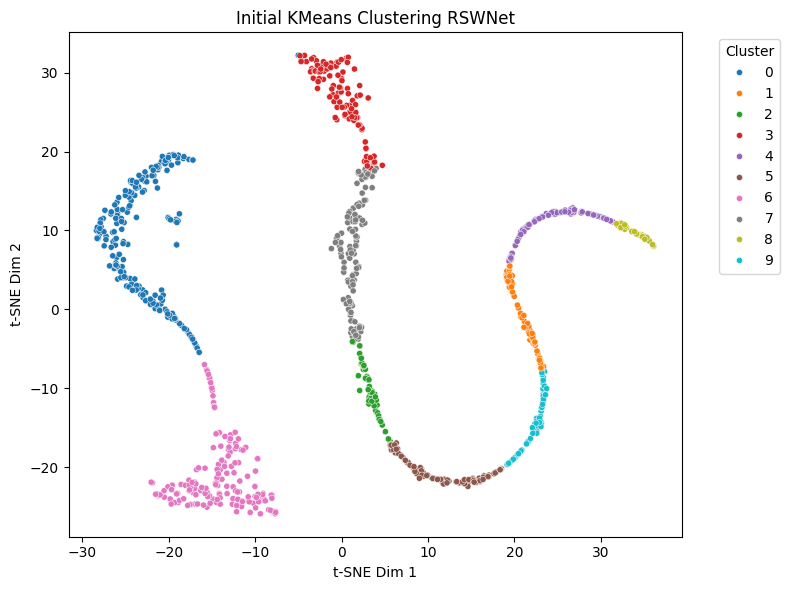

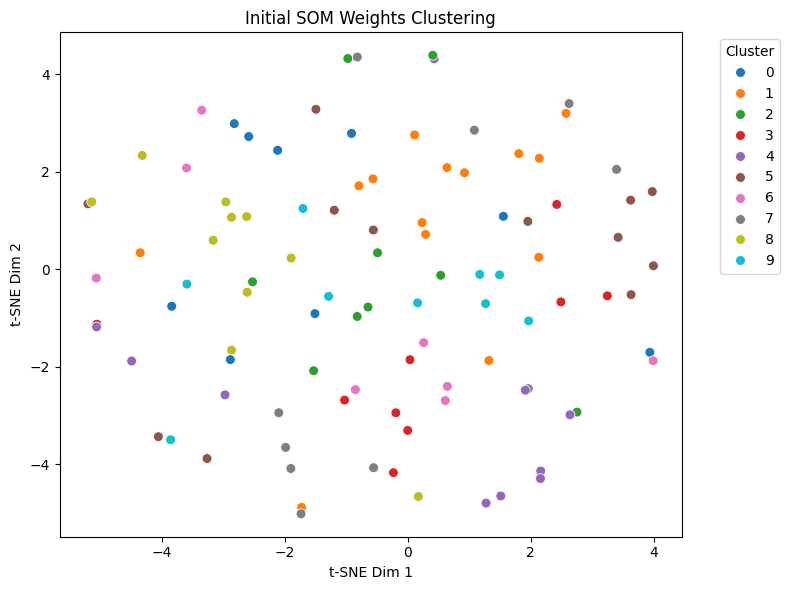

In [32]:
kmeans_init = KMeans(n_clusters=10, n_init=20, random_state=42)
initial_kmeans_labels = kmeans_init.fit_predict(latent_features)

som = SOM(map_size=(10, 10), input_dim=latent_dim)
initial_som_weights = som.weights.view(-1, latent_dim).cpu().numpy()
kmeans_som_init = KMeans(n_clusters=10, random_state=42)
initial_som_labels = kmeans_som_init.fit_predict(initial_som_weights)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
latents_2d = tsne.fit_transform(latent_features[:1000])   
som_weights_2d = tsne.fit_transform(initial_som_weights)  

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=latents_2d[:, 0], y=latents_2d[:, 1],
    hue=initial_kmeans_labels[:1000],
    palette='tab10', s=20, legend='full'
)
plt.title("Initial KMeans Clustering RSWNet")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Initial KMeans Clustering RSWNet")
plt.show()
plt.close()


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=som_weights_2d[:, 0], y=som_weights_2d[:, 1],
    hue=initial_som_labels,
    palette='tab10', s=50, legend='full'
)
plt.title("Initial SOM Weights Clustering")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Initial SOM Weights Clustering")
plt.show()
plt.close()

## SOM Trainining
---

In [33]:
som = SOM(map_size=(2, 5), input_dim=latent_dim)
max_iter = 1000
latent_tensor = torch.tensor(latent_features, dtype=torch.float32).to(device)
for t in range(max_iter):
    indices = np.random.permutation(latent_features.shape[0])[:128]
    batch = latent_tensor[indices]
    som.update(batch, t, max_iter)
    if (t + 1) % 100 == 0:
        print(f"SOM Iteration [{t+1}/{max_iter}]")

SOM Iteration [100/1000]
SOM Iteration [200/1000]
SOM Iteration [300/1000]
SOM Iteration [400/1000]
SOM Iteration [500/1000]
SOM Iteration [600/1000]
SOM Iteration [700/1000]
SOM Iteration [800/1000]
SOM Iteration [900/1000]
SOM Iteration [1000/1000]


In [35]:
latent_tensor = torch.tensor(test_latents, dtype=torch.float32).to(device)

# quantization error
with torch.no_grad():
    dists = torch.cdist(latent_tensor, som.weights.view(-1, som.input_dim)) 
    bmu_dists, _ = dists.min(dim=1) 
quant_error_som = bmu_dists.mean().item()


## SOM model summary
---

In [36]:
def som_detailed_summary(som):
    # Compute sizes
    rows, cols = som.map_size
    n_neurons = rows * cols
    w_shape = som.weights.shape          
    g_shape = som.grid.shape             
    # Parameter counts
    total_weights = som.weights.numel()
    total_grid_elems = som.grid.numel()
    
    print("Self-Organizing Map (SOM) Summary")
    print("="*40)
    print(f"Map size:        {som.map_size}   (total neurons: {n_neurons})")
    print(f"Input dim:       {som.input_dim}")
    print(f"Learning rate:   {som.learning_rate}")
    print(f"Sigma (radius):  {som.sigma}")
    print()
    print("Structure:")
    print(f"  ├─ weights (Parameter)    shape={tuple(w_shape)}    params={total_weights}")
    print(f"  └─ grid    (Buffer)       shape={tuple(g_shape)}    elems={total_grid_elems}")
    print()
    print("Parameter counts:")
    print(f"  Total params:           {total_weights + total_grid_elems}")
    print(f"  Trainable params:       {total_weights}")
    print(f"  Non-trainable params:   {total_grid_elems}")

som = SOM(map_size=(2,5), input_dim=latent_dim, learning_rate=0.5)
som_detailed_summary(som)


Self-Organizing Map (SOM) Summary
Map size:        (2, 5)   (total neurons: 10)
Input dim:       2048
Learning rate:   0.5
Sigma (radius):  2.5

Structure:
  ├─ weights (Parameter)    shape=(2, 5, 2048)    params=20480
  └─ grid    (Buffer)       shape=(2, 5, 2)    elems=20

Parameter counts:
  Total params:           20500
  Trainable params:       20480
  Non-trainable params:   20


## Quantitative Assessment of Clustering Performance of SOM
---

In [37]:
som_labels = som.predict(torch.tensor(test_latents, dtype=torch.float32).to(device))
sil_score_som = silhouette_score(test_latents, som_labels)
db_score_som = davies_bouldin_score(test_latents, som_labels)
ch_score_som = calinski_harabasz_score(test_latents, som_labels)

print("\nSOM Clustering Metrics:")
print(f"Silhouette Score:        {sil_score_som:.4f}")
print(f"Davies-Bouldin Index:    {db_score_som:.4f}")
print(f"Calinski-Harabasz Index: {ch_score_som:.4f}")
print(f"{'Quantization Error:':<25}{quant_error_som:.4f}")


SOM Clustering Metrics:
Silhouette Score:        -0.0334
Davies-Bouldin Index:    1.1796
Calinski-Harabasz Index: 867.1602
Quantization Error:      3.7813


## Visualization of SOM Clustering Using t-SNE
---

C:\Users\T2420322\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


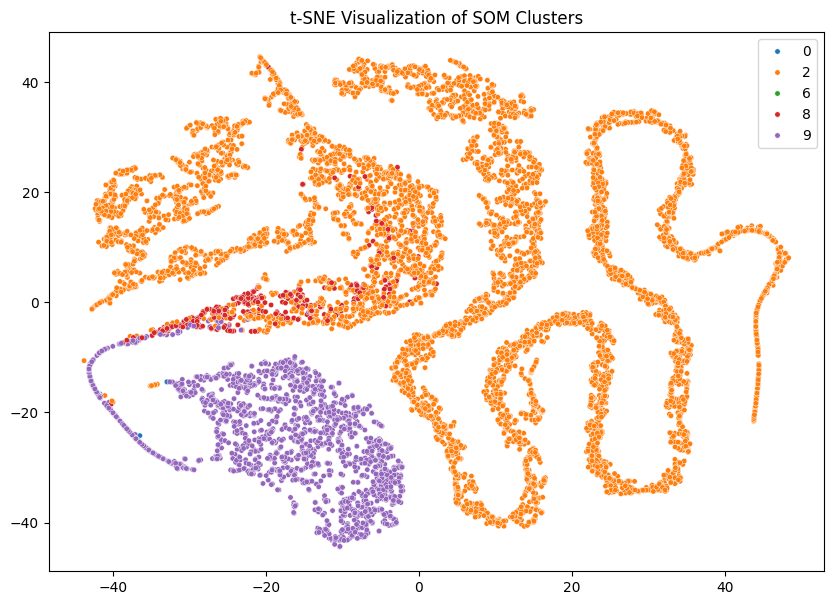

In [40]:
test_latents_2d = tsne.fit_transform(test_latents)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=test_latents_2d[:, 0], y=test_latents_2d[:, 1], hue=som_labels, palette='tab10', s=15)
plt.title("t-SNE Visualization of SOM Clusters")
plt.savefig('som_clustering.png')
plt.show()
plt.close()

# Quantitative Comparison of DEC and SOM Clustering Methods
---

In [39]:
print("\nComparison Table:")
print(f"{'Metric':<35} {'DEC':<10} {'SOM':<10}")
print(f"{'Silhouette Score':<35} {sil_score_rswNet:.4f}    {sil_score_som:.4f}")
print(f"{'Davies-Bouldin Index':<35} {db_score_rswNet:.4f}    {db_score_som:.4f}")
print(f"{'Calinski-Harabasz Index':<35} {ch_score_rswNet:.4f}    {ch_score_som:.4f}")
print(f"{'Final KL / Quantization Error':<35} {rswNet_val_kl:.4f}    {quant_error_som:.4f}")


Comparison Table:
Metric                              DEC        SOM       
Silhouette Score                    0.6799    -0.0334
Davies-Bouldin Index                0.4570    1.1796
Calinski-Harabasz Index             146067.7031    867.1602
Final KL / Quantization Error       0.0882    3.7813
